## Final Project - RFM Analysis

### Activities

In this project you will implement RFM analysis for analysing customers based on three factors: Recency, Frequency, and Monetary Value.

You will remove outliers from the dataset and apply K-means clustering to create clusters of customers exhibiting similar purchase behaviour.

---

#### Customer Segmentation Problem Statement


We have a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The company wants to segment its customers and determine marketing strategies according to these segments

The dataset consists of the following attributes:

- `InvoiceNo`: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

- `StockCode`: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

- `Description`: Product (item) name. Nominal.

- `Quantity`: The quantities of each product (item) per transaction. Numeric.

- `InvoiceDate`: Invoice Date and time. Numeric, the day and time when each transaction was generated. The date-time format used here is `yyyy-mm-dd hh:mm:ss`

- `UnitPrice`: Unit price. Numeric, Product price per unit in pound sterling, also known as GBP (Great Britain Pound).

- `CustomerID`: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

- `Country`: Country name. Nominal, the name of the country where each customer resides.



**Dataset Credits:** https://archive.ics.uci.edu/ml/datasets/online+retail

**Citation:** Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.


---

#### Loading the Dataset





**Dataset Link:** https://raw.githubusercontent.com/m-narayanan22/datasets/main/online-retail-customers.xlsx



In [63]:
# Read the dataset and create a Pandas DataFrame.
import pandas as pd
import numpy as np
import time, warnings
import datetime as dt
import matplotlib.pyplot as plt #for visulization
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from  sklearn.metrics import silhouette_score
warnings.filterwarnings("ignore") #for warings overriding 

# Read the dataset and create a Pandas DataFrame.
df_rfm = pd.read_excel("https://raw.githubusercontent.com/m-narayanan22/datasets/main/online-retail-customers.xlsx")
df_rfm.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [64]:
# Get the total number of rows and columns, data-types of columns and missing values (if exist) in the dataset. 
#for total number of rows and columns 
print(df_rfm.shape)
#for missing values 
print(df_rfm.isnull().sum())

(541909, 8)
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


---

#### Removing the Cancelled Orders



In [65]:
# Check the data type of 'InvoiceNo' field
df_rfm['InvoiceNo'].dtype #data type is object

dtype('O')

In [66]:
# Convert 'InvoiceNo' field to string and verify whether the data type is converted or not.
df_rfm['InvoiceNo'].astype(str)

0         536365
1         536365
2         536365
3         536365
4         536365
           ...  
541904    581587
541905    581587
541906    581587
541907    581587
541908    581587
Name: InvoiceNo, Length: 541909, dtype: object

In [67]:
# Use regex to find 'C' in the 'InvoiceNo' field
can_orders = df_rfm[df_rfm.InvoiceNo.str.contains('\D').replace(pd.NA,False)]
can_orders

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [68]:
# Check total number of orders including cancelled orders.
total_orders = df_rfm['StockCode'].value_counts() #StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
total_orders 

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

In [69]:
# Remove cancelled invoices from the dataset
df_rfm = df_rfm[df_rfm['Quantity']>0] #becasue cancelled orders quanitity value will be always less than 0
df_rfm.shape

(531285, 8)

---

#### Removing Missing Values

In [70]:
# Obtain the number of missing or null values in df
df_rfm.isnull().sum()

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133361
Country             0
dtype: int64

In [71]:
# Determine the percentage of null values in each column.
percent_of_null = df_rfm.isnull().sum()*100/len(df_rfm)
percent_of_null

InvoiceNo       0.000000
StockCode       0.000000
Description     0.111428
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.101593
Country         0.000000
dtype: float64

In [72]:
# Remove the null valued rows.
df_rfm.dropna(subset=['CustomerID','Description'],how='any',inplace=True)
#df_rfm.isnull().sum()

In [73]:
# Again obtain the number of null values in df.
df_rfm.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [74]:
# Check the data type of CustomerID column.
df_rfm['CustomerID'].dtype

dtype('float64')

In [75]:
# Convert 'CustomerID' field to integer based categorical column.
df_rfm['CustomerID'] = df_rfm['CustomerID'].apply(np.int64)
df_rfm['CustomerID'].dtype

dtype('int64')

---

#### RFM analysis



In [76]:
# S3.1: Check the first 5 samples of the dataframe
df_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [77]:
# Obtain the the total purchase amount for the customers
total_purchase_amt = df_rfm['UnitPrice'].sum()
total_purchase_amt

1240000.614

In [78]:
# Obtain the number of unique customers
from enum import unique
# Obtain the number of unique customers
unique_cust= df_rfm['CustomerID'].unique()
unique_cust

array([17850, 13047, 12583, ..., 13298, 14569, 12713])

In [79]:
# Obtain the Monetary information from the dataframe
df_rfm['Totalcost'] = df_rfm['Quantity']*df_rfm['UnitPrice']
df_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Totalcost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [80]:
# Obtain the Frequency information from the dataframe
#monetary_df.columns = ['CustomerID', 'Monetary']
monetary = df_rfm.groupby(by='CustomerID',as_index=False).agg({'Totalcost': 'sum'})
monetary.columns = ['CustomerID','Monetary']
monetary.tail()

,CustomerID,Monetary
4334,18280,180.60
4335,18281,80.82
4336,18282,178.05
4337,18283,2094.88
4338,18287,1837.28


---

#### Merging DataFrames



In [81]:
#calculating frequency of purchase
#frequency_df = df_rfm_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
#frequency_df.columns = ['CustomerID','Frequency']
#frequency_df.head()
frequency =df_rfm.groupby('CustomerID')['InvoiceNo'].count() #it gives the frequency of customer
frequency =frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [82]:
# Merge 'monetary_df' and 'frequency_df' dataframes.
temp_df = frequency.merge(monetary,on='CustomerID')
temp_df.columns =['CustomerID','Frequency','Monetary']
temp_df.head()

,CustomerID,Frequency,Monetary
0,12346,1,77183.60
1,12347,182,4310.00
2,12348,31,1797.24
3,12349,73,1757.55
4,12350,17,334.40


---

#### Calculating Recency


In [83]:
# Obtain the last purchase date for each customer
df_rfm['date'] = pd.DatetimeIndex(df_rfm['InvoiceDate']).date
df_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Totalcost,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01


In [84]:
df_rfm['InvoiceDate'].max() #last date 

Timestamp('2011-12-09 12:50:00')

In [85]:
now = dt.date(2011,12,9) #till inidciates recent date whicn means prasent
print(now)

2011-12-09


In [ ]:
# Obtain the last invoice date in the dataset.
# Obtain the days since last purchase made by a customer
# Extract days from datetime using 'dt.days' attribute

In [86]:
# Add 'recency_days' as column to the merged dataframe 'rfm_df'.
recency = df_rfm.groupby(by='CustomerID', as_index=False)['date'].max()
recency.columns = ['CustomerID','LastPurshaceDate']
recency.head()   #Definition of recency.......the quality state of being recent.
                 #here recent purchase



,CustomerID,LastPurshaceDate
0,12346,2011-01-18
1,12347,2011-12-07
2,12348,2011-09-25
3,12349,2011-11-21
4,12350,2011-02-02


In [87]:
recency['Recency'] = recency['LastPurshaceDate'].apply(lambda x: (now - x).days)
recency.head() #imp new data frame for further 

,CustomerID,LastPurshaceDate,Recency
0,12346,2011-01-18,325
1,12347,2011-12-07,2
2,12348,2011-09-25,75
3,12349,2011-11-21,18
4,12350,2011-02-02,310


In [88]:
#drop LastPurchaseDate as we don't need it anymore
recency.drop('LastPurshaceDate',axis=1,inplace=True)

In [89]:
recency.head()

,CustomerID,Recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


You now have a dataframe for RFM analysis consisting of the necessary fields to carry out the customer segmentation. 

Now analyse the `rfm_df` dataframe obtained after RFM analysis and prepare it for K-Means clustering.



---

#### Data Analysis

For clustering, the `CustomerID` field is not required hence it can be dropped form the `rfm_df` dataframe.

In [90]:
# Drop the 'CustomerIDl column
df_rfm.drop('CustomerID','',axis=1,inplace=True)



TypeError: ignored

Create histogram and boxplots to understand the distribution of `Monetary`, `Frequency`, and `Recency` columns.

Use `subplots()` function of `matplotlib.pyplot` module to display all the three histograms in the first row and the boxplots in the second row.

Follow the steps given below to create this subplot:
1. Call the `subplots()` function on an object of `matplotlib.pyplot` and unpack the figure and axis objects in two different variables, say `fig` and `axis`. Inside the `subplots()` function, pass:

  - `nrows = 2` and `ncols = 3` parameters to create a figure having 2 rows and 3 columns.

  - `figsize = (15, 5)` parameter to create the figure of 15 units wide and 5 units high.

  - `dpi = 100` parameter to further enlarge the figure based on their pixel density.

2. Construct a histogram to visualise the distribution of `Monetary` column using first row, first column subplot's axes i.e `axis[0, 0]`.

3. Construct a boxplot to visualise the distribution of `Monetary` column using second row, first column subplot's axes i.e `axis[1, 0]`.

4. Also call the `set_title()` function using the `axis[0, 0]` object to set the `title` for histogram and boxplot.

5. Similarly, construct histograms and boxplots for `Frequency` and `Recency` columns using the respective subplots's axes.

6. Call the `show()` function on the `matplotlib.pyplot` object.


In [91]:
#merge the Monetary,frequency and recancy
#merge with monetary dataframe to get a table with the 3 columns
#df = recency.merge(temp_df,on='CustomerID')
#use CustomerID as index
#df.set_index('CustomerID',inplace=True)
#check the head
#df.head()
df = pd.merge(recency,frequency, on ='CustomerID', how='inner')
df = pd.merge(df,monetary, on='CustomerID', how='inner')
df.columns =['CustomerID', 'Recency','Frequency','Monetary']
df

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,2,182,4310.00
2,12348,75,31,1797.24
3,12349,18,73,1757.55
4,12350,310,17,334.40
...,...,...,...,...
4334,18280,277,10,180.60
4335,18281,180,7,80.82
4336,18282,7,12,178.05
4337,18283,3,756,2094.88


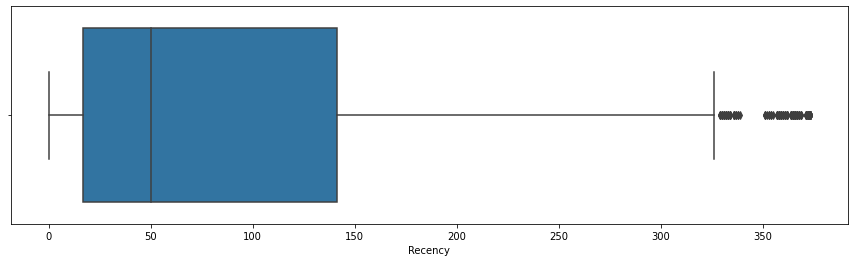

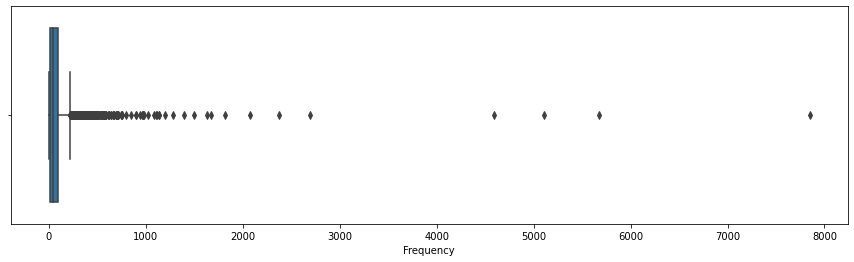

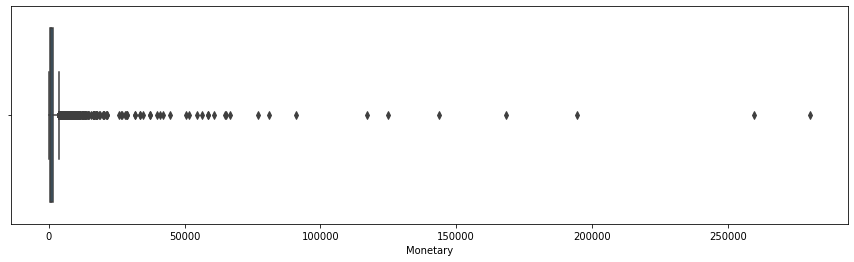

In [93]:
# Obtain the histogram and boxplots 
# Obtain the histogram and boxplots 
# Construct Histogram and Boxplot for 'Monetary'
plt.figure(figsize=(15,4))
sns.boxplot(df['Recency'], sym ='r+') 
plt.show()

# Construct Histogram and Boxplot for 'Frequency'
plt.figure(figsize=(15,4))
sns.boxplot(df['Frequency'], sym ='r+') 
plt.show()

# Construct Histogram and Boxplot for 'Recency'
plt.figure(figsize=(15,4))
sns.boxplot(df['Monetary'], sym ='r+') 
plt.show()




**Q**: Write your observatoions from the above plot.

**A**:we can obsereve that, outliers are in three plots are very high
so for better result we have to remove outliers 

Outliers: These are the points which lies beyond the "Minimum" and "Maximum" value. So any value more than the upper bound or lesser than the lower bound will be considered as outliers.

---

#### Remove Outliers

We had already learned how boxplots are useful in identifying outliers in column data in one of the previous lessons (*Lesson: Meteorite Landings - Box Plots*). Let us recall that.

**What are outliers?**
- Outlier is a value in a data series which is either very small or very large. 
- Outliers are abnormal values that can affect the overall observation due to its very high or very low extreme values.
- Hence they should be removed from the actual data.

The best way to detect outliers is to create a boxplot. It plots the minimum, first quartile, second quartile, third quartile and maximum values in the form of a box. Any value beyond minimum and maximum limit is considered as an outlier.


<center>
<img src= "https://s3-whjr-v2-prod-bucket.whjr.online/fc916def-1fd4-4a16-8a7f-caadecafdecc.jpg" height = 350 /></center>


- **Median or Second quartile ($Q2$):** The middle value of the dataset. Also known as $50^\text{th}$ percentile.
    
- **First quartile ($Q1$):** The middle value between the smallest value (not the "minimum") and the median of the dataset. Also known as $25^\text{th}$ percentile which means that $25\%$ of the data lies between smallest value and $Q1$.

- **Third quartile ($Q3$):** The middle value between the median and the highest value (not the "maximum") of the dataset. Also known as  $75^\text{th}$ percentile which means 75% of the data lies between smallest value and $Q3$. 

- **InterQuartile Range ($IQR$):**  $25^\text{th}$ to the  $75^\text{th}$ percentile. $IQR$ tells how spread the middle values are. It is defined as:

\begin{align}
IQR = Q3 - Q1
\end{align}

- **Minimum or Lower Bound:** $Q1 -1.5 \times IQR$

- **Maximum or Upper Bound:** $Q3 + 1.5 \times IQR$

- **Outliers:** These are the points which lies beyond the "Minimum" and "Maximum" value. So any value more than the upper bound or lesser than the lower bound will be considered as outliers.

Let's define a function `remove_outliers()` which removes outlier from the column data and returns an outlier free dataframe. This function takes two paramters as input:
 - `df`: The dataframe which consists of columns containing outliers.
 - `col`: The column of dataframe `df` from which the outliers needs to be flushed out.

Inside this funtion, 

1. Calculate $Q1$ or $25^\text{th}$ quartile for column `col` using `quantile()` function of `pandas` module and store it in a variable `q1`. Pass `0.25` as input to `quantile()` function.

  **Syntax of `quantile()` function:** `DataFrame.quantile(q)` where, `q` is the quantile to be computed. By default, `q = 0.5` ($50\%$ quantile)

2. Calculate $Q3$ or $75^\text{th}$ quartile for column `col` using `quantile()` function and store it in a variable `q3`. Pass `0.75` as input to `quantile()` function.

3. Calculate $IQR$ by subtracting `q3` from `q1` and store it in a variable `iqr`.

4. Calculate lower bound and upper bound using the following formula and store it in `lower_bound` and `upper_bound` variables respectively.

$$\text{Lower Bound}=Q1 - 1.5 \times IQR$$
$$\text{Upper Bound}=Q3 + 1.5 \times IQR$$

5. Obtain only those values from dataframe `df` which matches the following condition:

    `(df[col] >= lower_bound) & (df[col] <= upper_bound)`
  
  This condition will return those values of the column `col` which are between lower bound and upper bound.

6. Return the filtered dataframe.

**Note:** Here, the terms **quartile** and **quantile** are being used interchangeably. However, quantile is something which divides the dataset into equal parts. A quantile which divides the dataset into 4 equal parts i.e. at 0.25, 0.5 , 0.75, 1.00 is called a quartile. Thus, quartile is a type of quantile.


In [94]:
# Create a function for removing the outliers.
#define a function called 'outliers' which return a list of index of outliers
#iqr =q3-q2
#+/- 1.5*iqr

def remove_outliers(df, col):
  
  #for col in  col:

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    
    iqr = q3-q1

    lower_bound = q1-1.5*iqr
    upper_bound = q3 + 1.5*iqr

    new_df = df[(df[col]>=lower_bound) & (df[col]<=upper_bound)]

    #new_df = np.where(df[col]>upper_whisker, upper_whisker,np.where(df[col]<lower_whisker,lower_whisker,df[col]))
    
    return new_df


Now that you have created a function for removing outliers, we can easily remove outliers from `rfm_df` dataframe. 

To remove the outliers from the `Monetary` field:

1. Call the `remove_outliers()` function and pass `rfm_df` and  `'Monetary'` as input to this function. Save the returned dataframe in a variable `m_clean_df`.

2. Reset the index of `m_clean_df` dataframe using `reset_index(drop = True)` function. This function deletes the old index and resets the index in the new dataframe.

In [96]:
# Removing outliers from 'Monetary' field
m_clean_df = remove_outliers(df,'Monetary')
m_clean_df = m_clean_df.reset_index(drop = True) #dataframe without outliers
m_clean_df


,CustomerID,Recency,Frequency,Monetary
0,12348,75,31,1797.24
1,12349,18,73,1757.55
2,12350,310,17,334.40
3,12352,36,85,2506.04
4,12353,204,4,89.00
...,...,...,...,...
3907,18280,277,10,180.60
3908,18281,180,7,80.82
3909,18282,7,12,178.05
3910,18283,3,756,2094.88


Again create boxplots for `Recency`, `Monetary` and `Frequency` field and observe whether there is any improvement in data distribution. Use subplots to create these multiple plots.

In [99]:
features = ['Recency','Frequency','Monetary']
features

['Recency', 'Frequency', 'Monetary']

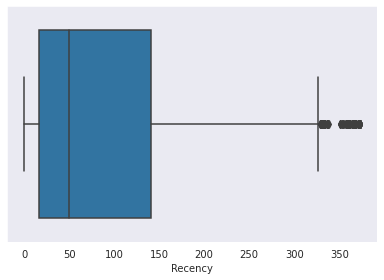

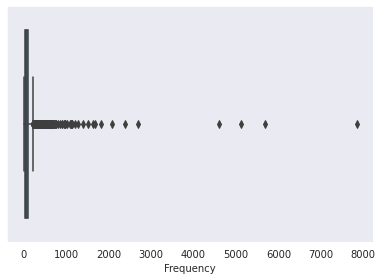

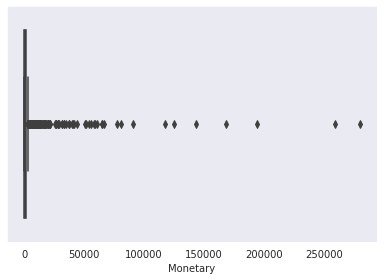

In [100]:
sns.set_style('dark')
for col in features:
  plt.figure(figsize=(16,4))
  plt.subplot(131)
  sns.boxplot(df[col])
  plt.tight_layout()
  plt.show()


In [109]:
df_cap =df.copy()

In [110]:
def iqr_capping(df1, cols, factor):
  
  for col in  cols:

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    
    iqr = q3-q1

    upper_whisker = q3 + (factor*iqr)
    lower_whisker = q1 - (factor*iqr)

    df[col] = np.where(df[col]>upper_whisker, upper_whisker,np.where(df[col]<lower_whisker,lower_whisker,df[col]))

In [111]:
iqr_capping(df_cap, features, 1.5)

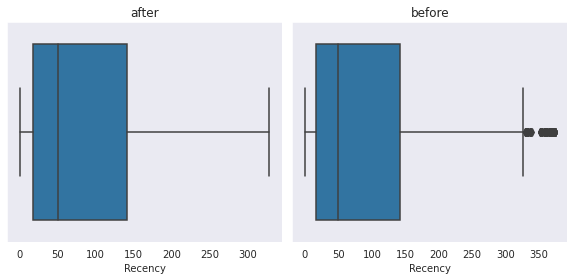

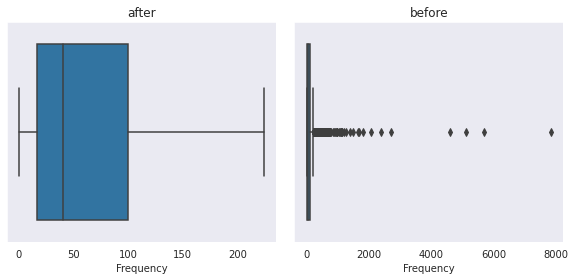

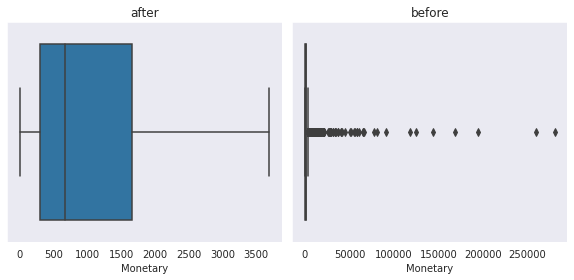

In [114]:
# Obtain the boxplots 
# Construct Boxplot for 'Monetary
# Construct Boxplot for 'Frequency'
# Construct Boxplot for 'Recency'
for col in features:
  plt.figure(figsize=(16,4))

  plt.subplot(141)    #subplot
  sns.boxplot(df[col])
  plt.title('after')

  plt.subplot(142)
  sns.boxplot(df_cap[col])
  plt.title('before')
  plt.tight_layout() #after means after removing the outliers from the dataframe
  plt.show()



**Q**: Write your observatoions from the above plot.

**A**:After removing the outliers, the distrubution of plot well distrubuted 

In [138]:
# Normalise the RFM parameters
scaler = StandardScaler()
rfm_normalized = m_clean_df[['Monetary','Frequency','Recency']] #reason fir changing the opsitions of cols is for clear look
rfm_normalized

,Monetary,Frequency,Recency
0,1797.24,31,75
1,1757.55,73,18
2,334.40,17,310
3,2506.04,85,36
4,89.00,4,204
...,...,...,...
3907,180.60,10,277
3908,80.82,7,180
3909,178.05,12,7
3910,2094.88,756,3


In [139]:
#for further refernce
rfm_normalized1 = rfm_normalized
rfm_normalized1

,Monetary,Frequency,Recency
0,1797.24,31,75
1,1757.55,73,18
2,334.40,17,310
3,2506.04,85,36
4,89.00,4,204
...,...,...,...
3907,180.60,10,277
3908,80.82,7,180
3909,178.05,12,7
3910,2094.88,756,3


In [140]:
rfm_normalized = scaler.fit_transform(rfm_normalized)
rfm_normalized =pd.DataFrame(rfm_normalized) #noralizing the values for elbow curve
rfm_normalized

,0,1,2
0,1.099421,-0.394646,-0.240195
1,1.051512,0.148701,-0.801453
2,-0.666340,-0.575761,2.073762
3,1.954997,0.303943,-0.624214
4,-0.962557,-0.743940,1.030020
...,...,...,...
3907,-0.851989,-0.666319,1.748824
3908,-0.972431,-0.705130,0.793701
3909,-0.855067,-0.640446,-0.909766
3910,1.458695,8.984552,-0.949153


Again create histograms for Monetary, Frequency and Recency columns to check whether all of them have similar mean and variance after standardisation.

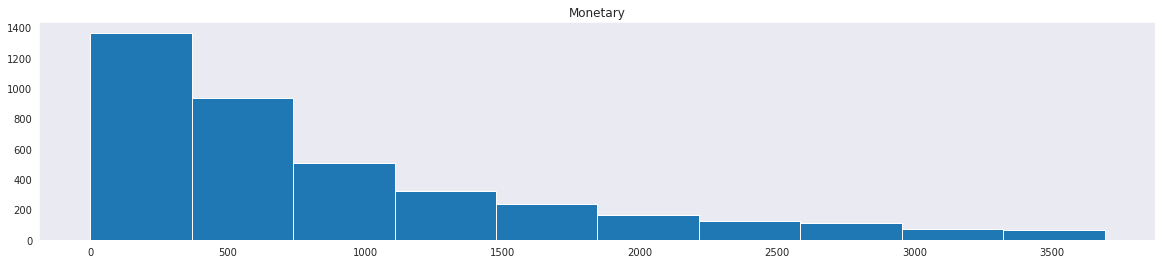

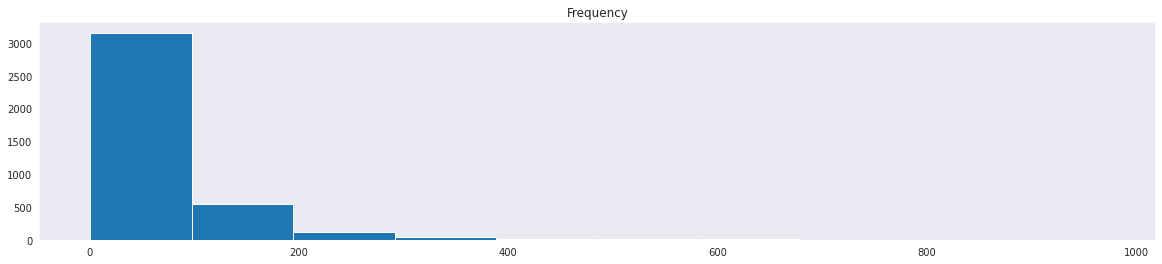

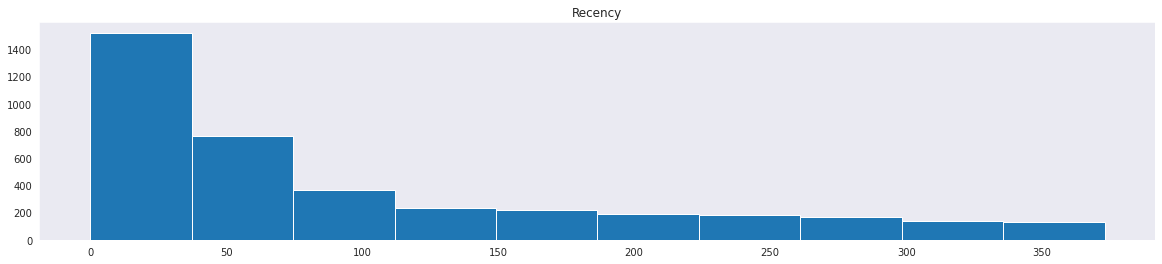

In [141]:
# Obtain the histograms.
# Construct Histogram for 'Monetary'
# Construct Histogram for 'Frequency'
# Construct Histogram for 'Recency'

# Construct Histogram for 'Monetary'
plt.figure(figsize=(20,4))
plt.hist(m_clean_df['Monetary'])
plt.title('Monetary')
plt.show()

                         
# Construct Histogram for 'Frequency'
plt.figure(figsize=(20,4))
plt.hist(m_clean_df['Frequency'])
plt.title('Frequency')
plt.show()

# Construct Histogram for 'Recency'
plt.figure(figsize=(20,4))
plt.hist(m_clean_df['Recency'])
plt.title('Recency')
plt.show()



You may note that all the columns now have same mean and variance. Now our dataframe is ready for K-Means clustering.

---

#### Applying K-Means clustering

Start by finding the optimal number of clusters for the K-Means algorithm. We will use the elbow method. 

Recall the steps for Elbow method:
1. Compute K-Means clustering for different values of `K` by varying `K` from `1` to `10` clusters.
2. For each K, calculate the total within-cluster sum of square (WCSS) using `inertia_` attribute of `KMeans` object.
3. Plot the curve of WCSS vs the number of clusters `K`.


In [142]:
# Determine 'K' using Elbow method.
# Initiate a for loop that ranges from 1 to 10.
# Plot WCSS vs number of clusters.
# Create an empty list to store wcss value obtained for each 'K' 
wcss = []

clusters = range(1, 10)
# Initiate a for loop that ranges from 1 to 10.
for k in clusters :
    # Inside for loop, perform K-means clustering for current value of K. Use 'fit()' to train the model.
    kmeans = KMeans(n_clusters = k, random_state = 10)
    kmeans.fit(rfm_normalized)
    # Find wcss for current K value using 'inertia_' attribute and append it to the empty list.
    wcss.append(kmeans.inertia_)

# Create a dataframe with two columns. 
# First column must contain K values from 1 to 10 and second column must contain wcss values obtained after the for loop.
wcss_data = pd.DataFrame({'Clusters': clusters, 'WCSS': wcss})
wcss_data

,Clusters,WCSS
0,1,11736.000000
1,2,6958.641094
2,3,4230.395542
3,4,3158.879653
4,5,2595.145262
5,6,2252.538970
6,7,1947.495499
7,8,1732.971721
8,9,1571.708230


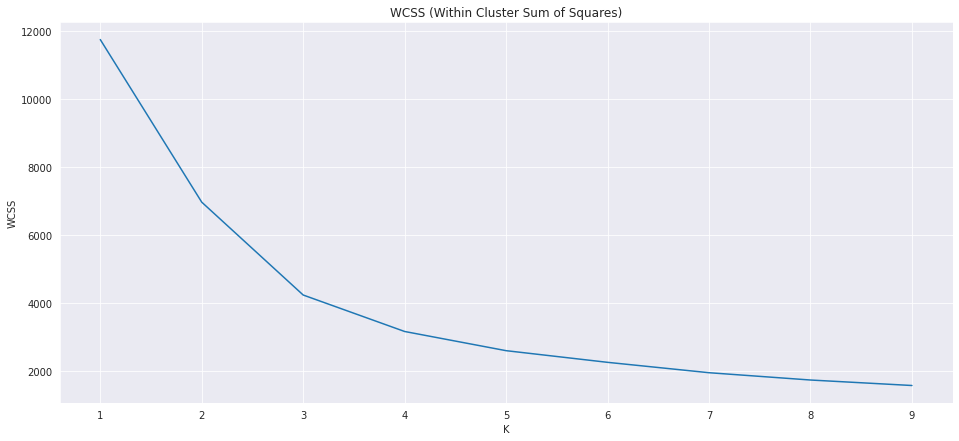

In [129]:
plt.figure(figsize=(16,7))
plt.title('WCSS (Within Cluster Sum of Squares)')
plt.plot(clusters, wcss)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.grid()
plt.xticks(range(1,10))
plt.show()

*********Elbow Method is one of the most popular methods to determine this optimal value of k.
Here, I tried to plot the cluster numbers as the x-axis and their respective score on the y axis. by observing the graph, using elbow divdin the dataset into 3 clsuters*******

**Q**: What is the optimal number of clusters?

**A**:Three

In [145]:
# Clustering the dataset
# Create a dataframe with cluster labels for cluster visualisation 
rfm_normalized1['Cluster labels']=kmeans.labels_
rfm_normalized1

,Monetary,Frequency,Recency,Cluster labels
0,1797.24,31,75,3
1,1757.55,73,18,3
2,334.40,17,310,2
3,2506.04,85,36,6
4,89.00,4,204,4
...,...,...,...,...
3907,180.60,10,277,2
3908,80.82,7,180,4
3909,178.05,12,7,8
3910,2094.88,756,3,5


Display those clusters using `scatter_3d()` function from `plotly.express` module.

In [146]:
# Visualise the clusters for customer segmentation
import plotly.express as px
fig = px.scatter_3d(rfm_normalized1, x='Monetary', y='Frequency',z='Recency',color='Cluster labels'
        )
fig.show()
#tight layout

**Summarising clusters:**

Calculate the mean recency, frequency and monetary values of all the clusters by applying `agg()` function on `km_df` dataframe.

In [147]:
# Understanding the Cluster Distribution
rfm_normalized1.agg(np.average)


Monetary          886.427887
Frequency          61.505624
Recency            99.393661
Cluster labels      4.116309
dtype: float64

**Q**: Write your observations from the clusters.

Here cluster-0 indicates best customer,  rfm characterstics is frequenct and recent shoppin and heavy spendin on shopping
here cluster 1 indicates, new customer, rfm characterstics is recent shoppin with low frequency
here cluster 2 indicates leaving customer/churned, frequen t and heavy shopping spent, only some time since last shopping
here cluster 3 indicates low frequency and spending

---

## **Report** 

Create a brief final report which explains all the useful insights you got from this project in a document or powerpoint. 

Submit the report along with the project.

---